Import libraries

In [ ]:
import keras, os, random, zipfile, csv
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
#from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers
#from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image
from PIL import Image
import torch
from torchvision import transforms
from keras.optimizers import SGD
!pip install keras-tuner
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.7 MB/s eta 0:00:00


Set Control Params

In [ ]:
train_the_model = 1
load_images_ndarray = 0;

Copy the files from the Drive

In [ ]:
from google.colab import drive
import shutil

drive.mount('/content/drive')
shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/Weights.csv', 'Weights.csv')
shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/Test_Ids.csv', 'Test_Ids.csv')
shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/arial.ttf', 'arial.ttf')
if train_the_model == 0:
    shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/Train_History_Dict', 'Train_History_Dict')
    shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/Trained_Reconstruction_Model.keras', 'Trained_Reconstruction_Model.keras')
if load_images_ndarray == 1:
    shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/train_images.npy', 'train_images.npy')
    shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/test_images.npy', 'test_images.npy')
    shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/train_labels.npy', 'train_labels.npy')
    shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/test_labels.npy', 'test_labels.npy')
else:
    shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/AP_LT.zip', 'AP_LT.zip')
drive.flush_and_unmount()


Mounted at /content/drive


Reading labels and Test IDs from the files downloaded from the google drive

In [ ]:
def read_lines(filepath):
    with open(filepath, 'rU') as data:
        reader = csv.reader(data)
        for row in reader:
            yield [ float(i) for i in row ]

Labels_filepath = 'Weights.csv'
Labels = list(read_lines(Labels_filepath))

Test_Ids_filepath = 'Test_Ids.csv'
Test_Ids = list(read_lines(Test_Ids_filepath))
Test_Ids_Temp = []
for line in Test_Ids:
    Test_Ids_Temp.extend(map(int, line))
Test_Ids = Test_Ids_Temp

<ipython-input-5-3df98f13c55c>:2: DeprecationWarning: 'U' mode is deprecated
  with open(filepath, 'rU') as data:


Read the .png images if .npy file is not available

In [ ]:
if load_images_ndarray == 0:
    image_zip_address = '/content/AP_LT.zip'
    images_dir = '/content/AP_LT/'

    with zipfile.ZipFile(image_zip_address, 'r') as zip_ref:
        zip_ref.extractall('/content')

Check the labels

In [ ]:
print(len(Test_Ids))
print(len(Labels))
print(len(Labels[0]))
print(Labels[0])
print(Labels[99])

3000
30000
22
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[-53.0016562455176, -30.3131156446782, 47.3368141254733, -67.2208429607154, 29.5636296995274, -52.4570058526085, -4.66390613952465, -52.6705109748065, 14.364206431397, 17.8423095307194, -17.1646559931991, 7.26353536949193, 3.46826093163362, 23.1762961044226, 2.35820155788212, 18.4643948449593, -1.96092188898584, -10.2321125554126, -0.00192204080546617, -0.0425926413902944, 0.299616671691781, -0.011302683168452]


Set the proper settings regarding the Dataset

In [ ]:
image_resolutions = [480, 280] # used 2*MV, files are indicated as old everywhere. Ran on March 17
image_resolutions = [490, 290] # Used 3*MV
image_resolutions = [890, 460] # Used 3*MV original size
image_resolutions = [623, 322] # Used 3*MV, cause the images are large for GPU memory
train_test_percentage = 0.1

**Split the Train and Test data randomly (With BG)**

In [ ]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(data, key=alphanum_key)

if load_images_ndarray == 0:

    files = sorted_alphanumeric(os.listdir(images_dir))
    # files.sort()
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []

    for idx, file in enumerate(files):
        my_image = tf.io.read_file(images_dir + file)
        # print(file)
        tensor = tf.io.decode_image(my_image, channels=1, dtype=tf.dtypes.uint8)
        tensor_image = tf.image.resize(tensor, [image_resolutions[0], image_resolutions[1]])
        tensor_image = tf.cast(tensor_image, dtype=tf.uint8)
        # tensor_image = tf.image.rgb_to_grayscale(tensor_image)
        # if len(tensor_image.shape) == 3:
        #    tensor_image = tf.expand_dims(tensor_image, axis=0)
        if (len(tensor_image.shape) > 3):
            print(tensor_image.shape)
            tensor_image = tf.squeeze(tensor_image, axis=0)
            print(tensor_image.shape)
        if Test_Ids.count(idx) > 0:
            test_images.append(tensor_image)
            test_labels.append(Labels[idx][:])
            # test_labels.append(Labels[idx][22:]) # Similarity Transformation only
            # test_labels.append(Labels[idx][0:1])
        else:
            if train_the_model == 1:
                train_images.append(tensor_image)
                train_labels.append(Labels[idx][:])
            else:
              if idx < 20: # We don't need the training images. In this way we will save memory
                train_images.append(tensor_image)
                train_labels.append(Labels[idx][:])
            # train_labels.append(Labels[idx][22:])
            # train_labels.append(Labels[idx][0:1])

    train_images = tf.stack(train_images)
    test_images = tf.stack(test_images)

    np.save('train_images.npy', train_images)
    np.save('test_images.npy', test_images)
    np.save('train_labels.npy', train_labels)
    np.save('test_labels.npy', test_labels)
    drive.mount('/content/drive')
    shutil.copy("train_images.npy", "/content/drive/MyDrive/2 - Reconstruction Network Data/train_images.npy")
    shutil.copy("test_images.npy", "/content/drive/MyDrive/2 - Reconstruction Network Data/test_images.npy")
    shutil.copy("train_labels.npy", "/content/drive/MyDrive/2 - Reconstruction Network Data/train_labels.npy")
    shutil.copy("test_labels.npy", "/content/drive/MyDrive/2 - Reconstruction Network Data/test_labels.npy")
    drive.flush_and_unmount()
else:
    train_images = np.load("train_images.npy")
    test_images = np.load("test_images.npy")
    train_labels = np.load("train_labels.npy")
    test_labels = np.load("test_labels.npy")

Mounted at /content/drive


Normalization of the output (Labels)

In [ ]:
labels_num = len(Labels)
feature_size = len(Labels[0])
feature_max_values = np.zeros((feature_size))
for i in range(feature_size):
  max_feature = 0;
  for j in range(labels_num):
    if max_feature < np.abs(Labels[j][i]): # max_feature < np.abs(Labels[j][i+22]):
      max_feature = np.abs(Labels[j][i]) # max_feature = np.abs(Labels[j][i+22]):
  feature_max_values[i] = max_feature

for i in range(feature_size):
  for j in range(len(train_labels)):
    train_labels[j][i] = train_labels[j][i]/feature_max_values[i]
  for j in range(len(test_labels)):
    test_labels[j][i] = test_labels[j][i]/feature_max_values[i]

train_labels = tf.stack(train_labels)
test_labels = tf.stack(test_labels)

Check the size of train and test sets

In [ ]:
print(len(train_images))
print(len(test_images))
print(len(train_labels))
print(len(test_labels))

27000
3000
27000
3000


Plot some images randomly

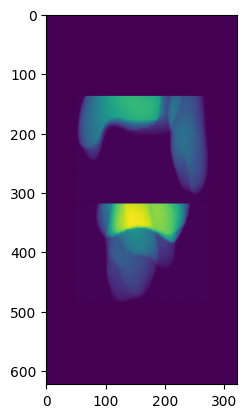

In [ ]:
%matplotlib inline

rand_idx = random.randint(0, len(test_images))
rand_idx = 0
im = test_images[rand_idx]
plt.imshow(im)

Check images dataset sizes

In [ ]:
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)

(27000, 623, 322, 1)
(3000, 623, 322, 1)
(27000, 22)
(3000, 22)


Create the model

Best run on Dec. 11
learning_rate = 0.1
batch_size = 10
dropout_rate = 0.2

In [ ]:
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Dropout

def create_model(image_resolutions, output_size, learning_rate, dropout_rate=0.2):
    model = Sequential()
    model.add(Conv2D(input_shape=(image_resolutions[0],image_resolutions[1],1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(units=4096, activation="relu"))
    model.add(Dropout(dropout_rate))  # Dropout layer after dense
    model.add(Dense(units=4096, activation="relu"))
    model.add(Dropout(dropout_rate))  # Dropout layer after dense
    model.add(Dense(units=output_size))

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate), loss='mean_absolute_error')  # SGD
    model.summary()
    return model

def scheduler(epoch, lr):
  match epoch:
    case 15:
         return lr*0.5
    case 30:
         return lr*0.5
    case 50:
         return lr*0.5
    case 70:
         return lr*0.5
    case _:
        return lr

# Loss functions
def weighted_MAE(y_true, y_pred):
    A = tf.math.subtract(y_true, y_pred);
    tf.print(A)
    print(type(y_true))
    print(type(y_pred))
    #print(MAE_weights)
    B = tf.math.multiply(MAE_weights, A)
    tf.math.reduce_mean(B)
    tf.print(B)
    return B

Create a dummy network to plot the architecture

In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
network_output_size = 22
learning_rate = 0.15
batch_size = 8 # 10
dropout_rate = 0.1
early_stopping = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
#lr_shceduler = keras.callbacks.LearningRateScheduler(scheduler)
# Adjust the learning rate when the loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',   # The metric to monitor
    factor=0.5,           # The factor by which to decrease the learning rate (e.g., halve the LR)
    patience=10,           # How many epochs to wait before reducing the LR
    min_lr=1e-6,          # The minimum learning rate (you can set it to a small value)
    verbose=1             # Print updates when the learning rate is reduced
)
#MAE_weights = np.array(MAE_weights);
#MAE_weights = np.tile(MAE_weights, (1,batch_size))
#MAE_weights = tf.cast(tf.transpose(tf.convert_to_tensor(MAE_weights)), tf.float32)
model = create_model(image_resolutions, network_output_size, learning_rate, dropout_rate)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 623, 322, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 623, 322, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 311, 161, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 311, 161, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 311, 161, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 155, 80, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 155, 80, 256)        │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 155, 80, 256)        │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 155, 80, 256)        │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 77, 40, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 77, 40, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 77, 40, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 77, 40, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 38, 20, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 38, 20, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 38, 20, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 38, 20, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 19, 10, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 97280)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │     398,462,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 430,047,958 (1.60 GB)

 Trainable params: 430,047,958 (1.60 GB)

 Non-trainable params: 0 (0.00 B)

Plot the architecture

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 47.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


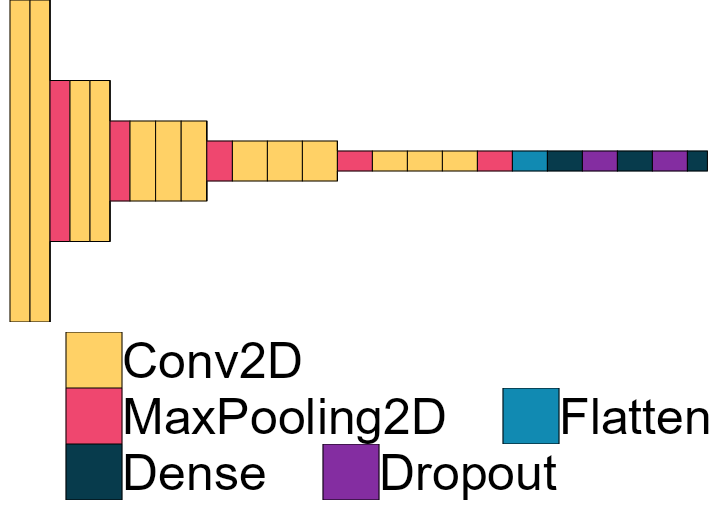

In [ ]:
!pip3 install visualkeras
import visualkeras
from PIL import ImageFont
from collections import defaultdict
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
font = ImageFont.truetype("arial.ttf", 50)
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'
visualkeras.layered_view(model, legend=True,spacing=0,color_map=color_map, scale_xy=1, scale_z=0.1, max_z=35, font=font, draw_volume=False)

Remove the dummy network

In [ ]:
import pickle
if train_the_model == 0:
    #model = tf.keras.models.load_model('Trained_Reconstruction_Model.keras')
    with open('Train_History_Dict', "rb") as file_pi:
        history = pickle.load(file_pi)

Hyperparemters tuning: Dropout rate, Learning rate, batchsize

In [ ]:
import pickle

if train_the_model == 1:

    history = model.fit(
      x=train_images,
      y=train_labels,
      epochs=400,
      batch_size=batch_size,
      shuffle=True,
      validation_split=0.1,
      verbose=1,
      callbacks = [early_stopping, lr_scheduler]
    )
    model.save('Trained_Reconstruction_Model.keras')
    with open('Train_History_Dict', 'wb') as file_pi:
        pickle.dump(history, file_pi)

    drive.mount('/content/drive')
    shutil.copy("Train_History_Dict", "/content/drive/MyDrive/2 - Reconstruction Network Data/Train_History_Dict")
    shutil.copy("Trained_Reconstruction_Model.keras", "/content/drive/MyDrive/2 - Reconstruction Network Data/Trained_Reconstruction_Model.keras")
    drive.flush_and_unmount()

Epoch 1/400
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 225s 68ms/step - loss: 0.2479 - val_loss: 0.1717 - learning_rate: 0.1500
Epoch 2/400
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 186s 61ms/step - loss: 0.1450 - val_loss: 0.1030 - learning_rate: 0.1500
Epoch 3/400
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 185s 61ms/step - loss: 0.0964 - val_loss: 0.0916 - learning_rate: 0.1500
Epoch 4/400
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 185s 61ms/step - loss: 0.0754 - val_loss: 0.0693 - learning_rate: 0.1500
Epoch 5/400
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 186s 61ms/step - loss: 0.0644 - val_loss: 0.0570 - learning_rate: 0.1500
Epoch 6/400
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 186s 61ms/step - loss: 0.0577 - val_loss: 0.0525 - learning_rate: 0.1500
Epoch 7/400
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 186s 61ms/step - loss: 0.0528 - val_loss: 0.0486 - learning_rate: 0.1500
Epoch 8/400
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 186s 61ms/step - loss: 0.0494 - val_loss: 0.0475 - learning_rate: 0.1500
Epoch 9/400
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 185s 61ms/step - loss: 0.0467

In [ ]:
import pickle
if train_the_model == 0:
    best_model = tf.keras.models.load_model('Trained_Reconstruction_Model.keras')
    with open('Train_History_Dict', "rb") as file_pi:
        history = pickle.load(file_pi)

In [ ]:
len(train_images)

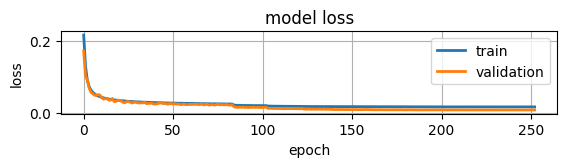

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'],linewidth=2)
plt.plot(history.history['val_loss'],linewidth=2)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
font = {'weight' : 'bold',
        'size'   : 11}
plt.rc('font', **font)
plt.grid()

plt.gca().set_aspect(200)
plt.show()

In [ ]:
predictions = model.predict(test_images)
test_prediction = tf.convert_to_tensor(predictions)
mae = tf.keras.losses.MeanAbsoluteError()
mae(test_prediction,test_labels).numpy()

94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 142ms/step


0.018553415

In [ ]:
mae = tf.keras.losses.MeanAbsoluteError()
print(mae)
for i in range(len(Labels[0])):
    print(mae(test_prediction[:][i], test_labels[:][i]).numpy())
    if i > 21 and i < 25:  # i = 0 .. 21 are MVs, i = 22,23,24 are Rotations, i = 25 is Scale
        print(mae(test_prediction[:][i], test_labels[:][i]).numpy()*feature_max_values[i]*180/np.pi)
        print(feature_max_values[i]*180/np.pi)
    else:
        print(mae(test_prediction[:][i], test_labels[:][i]).numpy()*feature_max_values[i])
        print(feature_max_values[i])
    print("*********************************")

0.040173486
9.23689585941594
229.925177220786
*********************************
0.022576189
4.578287181877141
202.79274101935
*********************************
0.041961182
8.313229442754528
198.117142191412
*********************************
0.022668142
3.470832395337312
153.114993499837
*********************************
0.023391249
3.3072897285265634
141.390046202305
*********************************
0.033465452
3.948139596840818
117.976578913931
*********************************
0.029842136
3.1873368771537454
106.806591574616
*********************************
0.044430867
3.8419258540280574
86.469747891241
*********************************
0.045523487
3.6529761122026754
80.2437675672389
*********************************
0.038724758
2.9884186629938343
77.1707516869644
*********************************
0.05046431
3.773832009154922
74.7821981059851
*********************************
0.046468064
3.1862779377513135
68.5691989404738
*********************************
0.022536593
1.439416095600

In [ ]:
import pandas as pd
result = np.zeros([len(test_prediction), len(test_prediction[0])])
for i in range(len(test_prediction)):
  for j in range(len(test_prediction[i])):
    result[i][j] = test_prediction[i][j].numpy()*feature_max_values[j]
df = pd.DataFrame(result)
df.to_csv('Reconstruction_Result.csv', index=False)

drive.mount('/content/drive')
shutil.copy("Reconstruction_Result.csv", "/content/drive/MyDrive/2 - Reconstruction Network Data/Reconstruction_Result.csv")
drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
"""
print('[ ...')
for i in range(len(test_labels)):
  for j in range(len(test_labels[i])):
    print(test_prediction[i][j].numpy()*feature_max_values[j], ',', end='')
  print(';...')
print('];')
"""

In [ ]:
predictions = model.predict(train_images)
train_prediction = tf.convert_to_tensor(predictions)
mae = tf.keras.losses.MeanAbsoluteError()
mae(train_prediction,train_labels).numpy()

844/844 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step


0.0036047923

In [ ]:
import pandas as pd
result = np.zeros([len(train_prediction), len(train_prediction[0])])
for i in range(len(train_prediction)):
  for j in range(len(train_prediction[i])):
    result[i][j] = train_prediction[i][j].numpy()*feature_max_values[j]
df = pd.DataFrame(result)
df.to_csv('Reconstruction_Result_Train.csv', index=False)

drive.mount('/content/drive')
shutil.copy("Reconstruction_Result_Train.csv", "/content/drive/MyDrive/2 - Reconstruction Network Data/Reconstruction_Result_Train.csv")
drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
from google.colab import runtime
runtime.unassign()